# Exercises 1

Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

In [1]:
# Import necessary libraries
import os
import datetime
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

print(tf.__version__)

2.12.0


## Import data and explore it

In [2]:
# Get some data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-14 08:36:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.193.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   210MB/s    in 0.8s    

2023-07-14 08:36:15 (210 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many directory and image we have?
for dir in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon

## Set data loader

In [4]:
# Creating train and test directory paths
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [5]:
# Set global variables
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Set data loader
print('Train data: ')
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMAGE_SIZE,
                                                                 batch_size=BATCH_SIZE)
print('\n')

print('Test data: ')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Train data: 
Found 750 files belonging to 10 classes.


Test data: 
Found 2500 files belonging to 10 classes.


In [6]:
# Check the train batch dataset
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
# How many classes we have?
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Data Augmentation

In [8]:
# Create data augmentation
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal_and_vertical'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
])

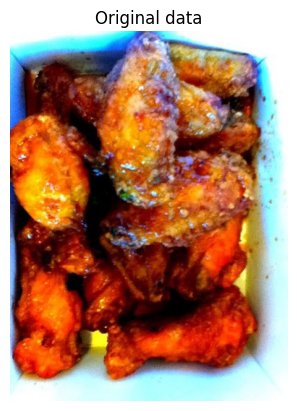

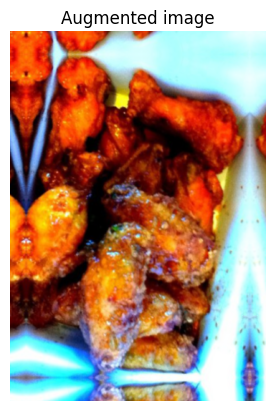

In [9]:
# View a random image and compare it with data augmented version
target_class = random.choice(train_data.class_names)
target_dir = '10_food_classes_10_percent/test/' + target_class
random_image = target_dir + '/' + random.choice(os.listdir(target_dir))

# Plot the original image
img = mpimg.imread(random_image)
plt.imshow(img)
plt.title('Original data')
plt.axis(False)
plt.show()

# Plot the augmented image
augmented_image = data_augmentation(img)
plt.imshow(augmented_image/255.)
plt.title('Augmented image')
plt.axis(False)
plt.show()

## ModelCheckpoint

In [10]:
# Set a checkpoint path
checkpoint_path = 'check_point_directory/checkpoint.ckpt'

# Create a checkpoint that saves only weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_freq='epoch',
                                                         save_best_only=False,
                                                         save_weights_only=True)

## Create a model

In [11]:
# Set the input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [12]:
# Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')

# Add data augmentation in model as a layer
x = data_augmentation(inputs)

# Give base_model the input and dont train it
x = base_model(x, training=False)

# Pool output feature ıf the output model
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer as the output layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
model_1_history = model_1.fit(train_data,
                              epochs=10,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)), # %25 of test data for validation
                              callbacks=[checkpoint_callback])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9850 - accuracy: 0.3347
Epoch 1: saving model to check_point_directory/checkpoint.ckpt
24/24 [==============================] - 32s 727ms/step - loss: 1.9850 - accuracy: 0.3347 - val_loss: 1.4576 - val_accuracy: 0.6595
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3435 - accuracy: 0.6733
Epoch 2: saving model to check_point_directory/checkpoint.ckpt
24/24 [==============================] - 14s 555ms/step - loss: 1.3435 - accuracy: 0.6733 - val_loss: 1.0285 - val_accuracy: 0.7730
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0419 - accuracy: 0.7440
Epoch 3: saving model to check_point_directory/checkpoint.ckpt
24/24 [==============================] - 12s 483ms/step - loss: 1.0419 - accuracy: 0.7440 - val_loss: 0.8320 - val_accuracy: 0.8026
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.8837 - accuracy: 0.7707
Epoch 4: saving model to check_point_di

## Evaluate the model

In [13]:
# Evaluate the model with all test data
model_1.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.5345 - accuracy: 0.8468


[0.5344548225402832, 0.8468000292778015]

In [15]:
# import helper functions.py
from helper_functions import plot_loss_curves

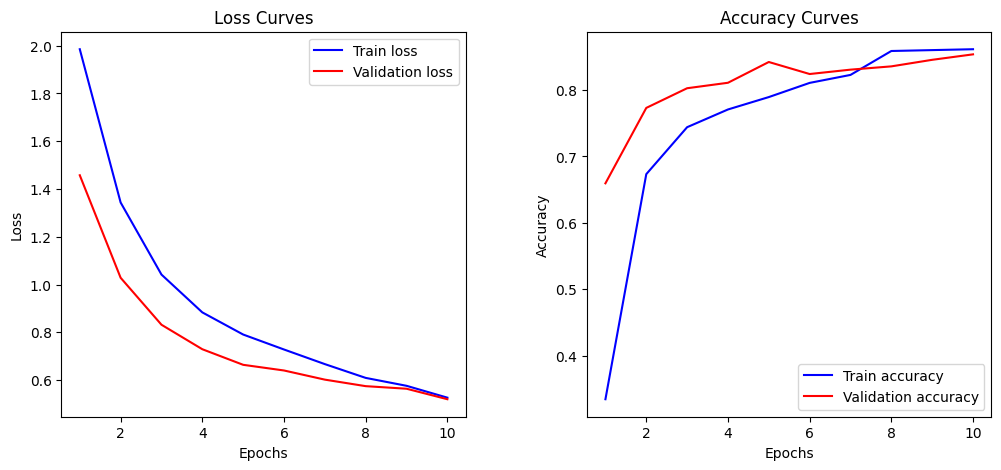

In [16]:
# Plot the loss curves
plot_loss_curves(model_1_history)

Hmmm. Our loss curves looks very cool and our score is really good. But let's try to improve that.

# Exercise 2

Fine-tune the last 20 layers of the base model and add another 10 epochs.

In [17]:
# Set the base model trainable
base_model.trainable = True

# Set the all layers not trainable except last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [18]:
# Check out the layer trainable
for index, layer in enumerate(base_model.layers):
    print(index, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

As you see above, last 20 layer is traniable but other is not. Now, we need to recompile our model.

In [19]:
# Recompile the model
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [20]:
# Set the fine tune epoch
fine_tune_epochs = len(model_1_history.epoch) + 10

# Fit the model
model_2_history = model_1.fit(train_data,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              initial_epoch=model_1_history.epoch[-1])

Epoch 10/20
24/24 [==============================] - 26s 576ms/step - loss: 0.4690 - accuracy: 0.8533 - val_loss: 0.4377 - val_accuracy: 0.8503
Epoch 11/20
24/24 [==============================] - 9s 367ms/step - loss: 0.3782 - accuracy: 0.8773 - val_loss: 0.4685 - val_accuracy: 0.8470
Epoch 12/20
24/24 [==============================] - 9s 377ms/step - loss: 0.3212 - accuracy: 0.8920 - val_loss: 0.4288 - val_accuracy: 0.8734
Epoch 13/20
24/24 [==============================] - 10s 428ms/step - loss: 0.2639 - accuracy: 0.9293 - val_loss: 0.4817 - val_accuracy: 0.8503
Epoch 14/20
24/24 [==============================] - 8s 339ms/step - loss: 0.2558 - accuracy: 0.9227 - val_loss: 0.4652 - val_accuracy: 0.8569
Epoch 15/20
24/24 [==============================] - 10s 391ms/step - loss: 0.1924 - accuracy: 0.9493 - val_loss: 0.4302 - val_accuracy: 0.8602
Epoch 16/20
24/24 [==============================] - 10s 392ms/step - loss: 0.1788 - accuracy: 0.9533 - val_loss: 0.4489 - val_accuracy: 0.

In [21]:
# Evaluate the model with all test data
model_1.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.4478 - accuracy: 0.8548


[0.44781455397605896, 0.8547999858856201]

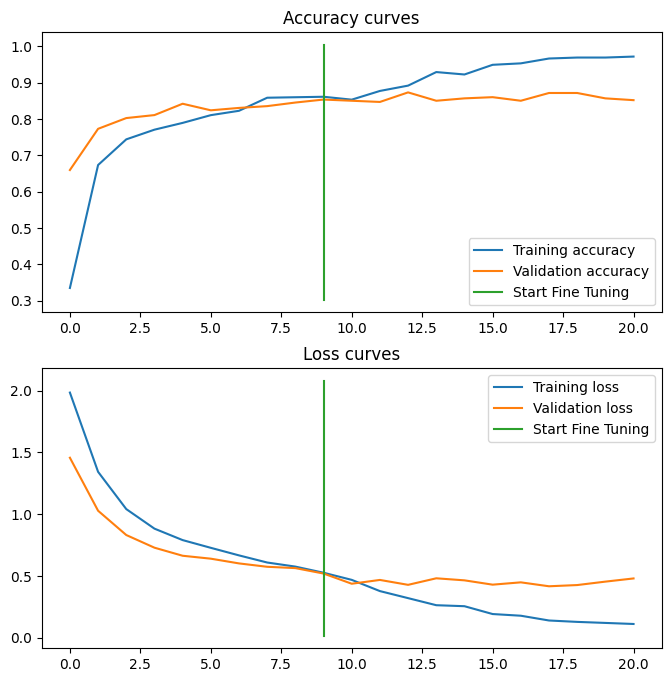

In [22]:
# Get the loss curves
from helper_functions import compare_histories
compare_histories(model_1_history, model_2_history, initial_epoch=10)

I guess, our model trainable layers haven't work well as we expect. We get a little better results however we so close the overfit. Let's create one more model.

# Exercise 3

Fine-tune the last 30 layers of the base model and add another 10 epochs.

In [23]:
# Set the base model trainable
base_model.trainable = True

# Set the all layers not trainable except last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [24]:
# Check out the layer trainable
for index, layer in enumerate(base_model.layers):
    print(index, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [25]:
# Recompile the model
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [26]:
# Set the fine tune epoch
fine_tune_epochs = len(model_1_history.epoch) + 10

# Fit the model
model_3_history = model_1.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              initial_epoch=model_1_history.epoch[-1])

Epoch 10/20
24/24 [==============================] - 22s 419ms/step - loss: 0.0926 - accuracy: 0.9800 - val_loss: 0.4787 - val_accuracy: 0.8569
Epoch 11/20
24/24 [==============================] - 8s 341ms/step - loss: 0.0854 - accuracy: 0.9787 - val_loss: 0.5352 - val_accuracy: 0.8536
Epoch 12/20
24/24 [==============================] - 9s 355ms/step - loss: 0.0739 - accuracy: 0.9813 - val_loss: 0.5412 - val_accuracy: 0.8470
Epoch 13/20
24/24 [==============================] - 8s 335ms/step - loss: 0.0787 - accuracy: 0.9800 - val_loss: 0.4644 - val_accuracy: 0.8734
Epoch 14/20
24/24 [==============================] - 8s 309ms/step - loss: 0.0541 - accuracy: 0.9893 - val_loss: 0.5057 - val_accuracy: 0.8618
Epoch 15/20
24/24 [==============================] - 9s 363ms/step - loss: 0.0385 - accuracy: 0.9960 - val_loss: 0.5485 - val_accuracy: 0.8553
Epoch 16/20
24/24 [==============================] - 8s 304ms/step - loss: 0.0517 - accuracy: 0.9840 - val_loss: 0.5804 - val_accuracy: 0.850

In [27]:
# Evaluate the model with all test data
model_1.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5188 - accuracy: 0.8608


[0.518837034702301, 0.86080002784729]

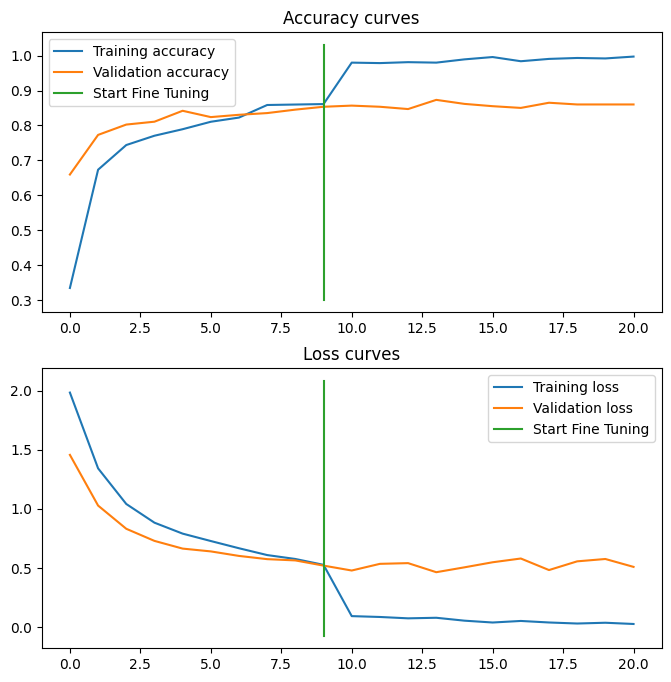

In [28]:
# Plot the all curves
compare_histories(model_1_history, model_3_history, initial_epoch=10)

It appears that our model overfits because the validation score remains the same despite the validation scores decreasing. Let's use one more data but we need to use all data not only %10 percent.

# Exercise 4

Fine-tune the last 30 layers of the base model and add another 10 epochs with the all data.

In [29]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
zip_ref = zipfile.ZipFile('10_food_classes_all_data.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-14 08:46:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   112MB/s    in 6.8s    

2023-07-14 08:46:55 (73.0 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [30]:
# How many directory and image we have?
for dir in os.walk('10_food_classes_all_data'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_all_data'
There are 10 directories and 0 images in '10_food_classes_all_data/test'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'
There are 10 directori

In [31]:
# Creating train and test directory paths
train_dir_all = '10_food_classes_all_data/train/'
test_dir_all = '10_food_classes_all_data/test/'

In [32]:
# Set data loader
print('Train data: ')
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all,
                                                                 label_mode='categorical',
                                                                 image_size=IMAGE_SIZE,
                                                                 batch_size=BATCH_SIZE)
print('\n')

print('Test data: ')
test_data_all = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_all,
                                                                label_mode='categorical',
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Train data: 
Found 7500 files belonging to 10 classes.


Test data: 
Found 2500 files belonging to 10 classes.


In [33]:
# Set the fine tune epoch
fine_tune_epochs = len(model_1_history.epoch) + 10

# Fit the model
model_4_history = model_1.fit(train_data_all,
                              epochs=fine_tune_epochs,
                              validation_data=test_data_all,
                              validation_steps=int(0.25*len(test_data_all)),
                              initial_epoch=model_1_history.epoch[-1])

Epoch 10/20
235/235 [==============================] - 55s 233ms/step - loss: 0.5953 - accuracy: 0.8180 - val_loss: 0.2709 - val_accuracy: 0.9128
Epoch 11/20
235/235 [==============================] - 51s 215ms/step - loss: 0.4322 - accuracy: 0.8637 - val_loss: 0.2572 - val_accuracy: 0.9227
Epoch 12/20
235/235 [==============================] - 48s 199ms/step - loss: 0.3674 - accuracy: 0.8807 - val_loss: 0.2495 - val_accuracy: 0.9194
Epoch 13/20
235/235 [==============================] - 48s 200ms/step - loss: 0.3221 - accuracy: 0.8944 - val_loss: 0.2132 - val_accuracy: 0.9211
Epoch 14/20
235/235 [==============================] - 44s 187ms/step - loss: 0.2826 - accuracy: 0.9073 - val_loss: 0.2177 - val_accuracy: 0.9145
Epoch 15/20
235/235 [==============================] - 40s 170ms/step - loss: 0.2387 - accuracy: 0.9208 - val_loss: 0.2115 - val_accuracy: 0.9178
Epoch 16/20
235/235 [==============================] - 42s 175ms/step - loss: 0.2072 - accuracy: 0.9317 - val_loss: 0.2290 -

In [34]:
# Evaluate the model with all test data
model_1.evaluate(test_data_all)

79/79 [==============================] - 7s 80ms/step - loss: 0.2324 - accuracy: 0.9256


[0.23239101469516754, 0.925599992275238]

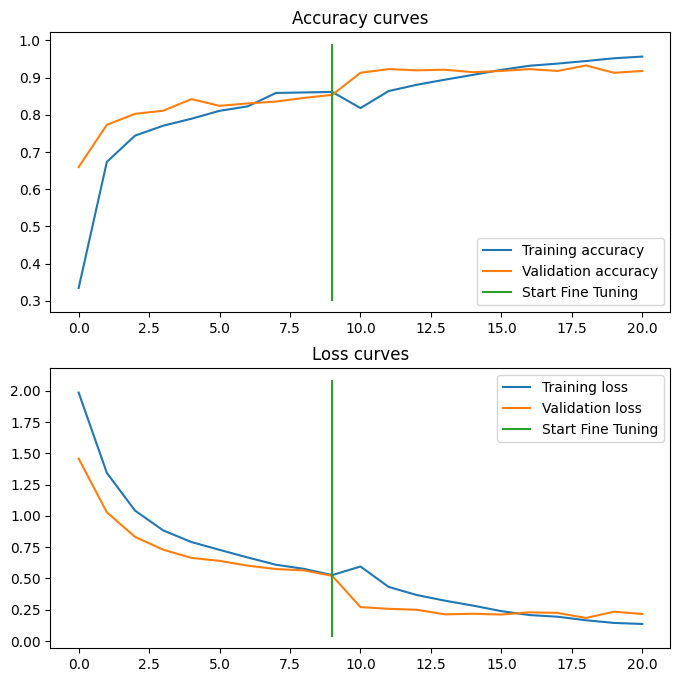

In [35]:
# Plot the loss curves
compare_histories(model_1_history, model_4_history, initial_epoch=10)

# Exercise 5

Write a function to visualize an image from test data and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [144]:
# Import neccessary libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [270]:
# Create a random image from test data set and get it path
def create_random_image_and_path():
    target_class = random.choice(test_data.class_names)
    target_dir = '10_food_classes_10_percent/test/' + target_class
    random_image_path = target_dir + '/' + random.choice(os.listdir(target_dir))
    return random_image_path

In [277]:
# Create an image path
random_image_path = create_random_image_and_path()
random_image_path

'10_food_classes_10_percent/test/steak/2229090.jpg'

In [298]:
# Make a prediction and plot the random image
def pred_and_plot(image_path, model, target_size=(224, 224)):
    # Load image
    img = image.load_img(image_path, target_size=target_size)
    # Convert image into array
    x = image.img_to_array(img)
    # Calculate the probabilities
    prob = model_1.predict(tf.expand_dims(x, axis=0), verbose=0)[0]
    # Prediction class
    pred = test_data.class_names[np.argmax(prob)]
    max_prob = '{:.2f}'.format(max(prob))

    # Plot image and predicted class
    img_ = mpimg.imread(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_)
    plt.title(f"Orijinal Image: {image_path.split('/')[2]}\nModel Prediction: {pred}\nProbability: {max_prob}", color='green')
    plt.axis(False)
    plt.show()

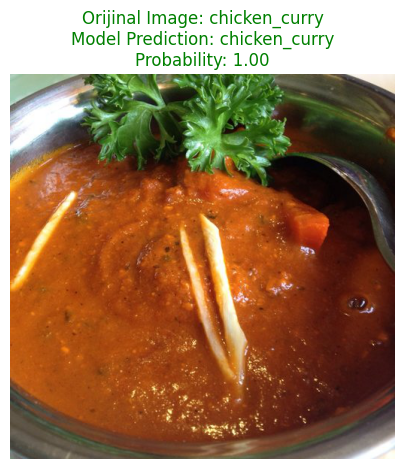

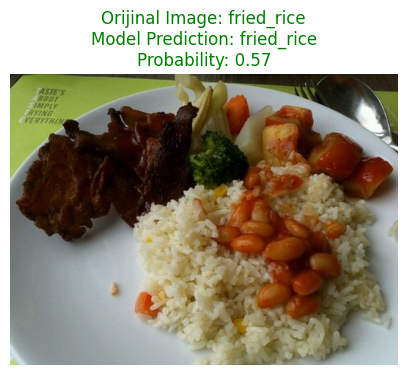

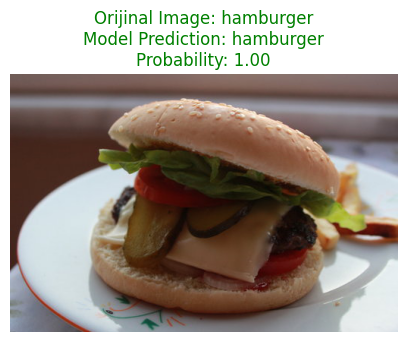

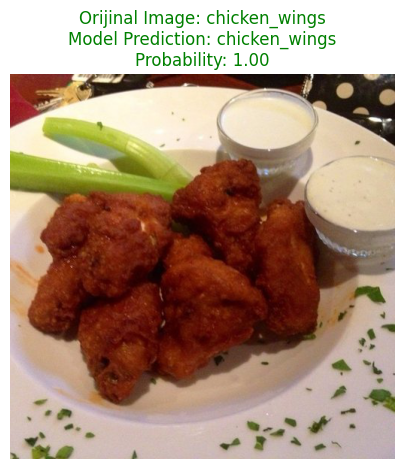

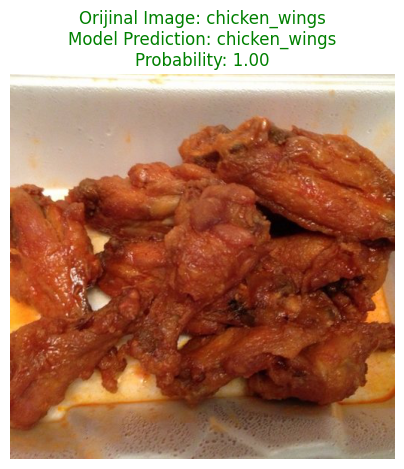

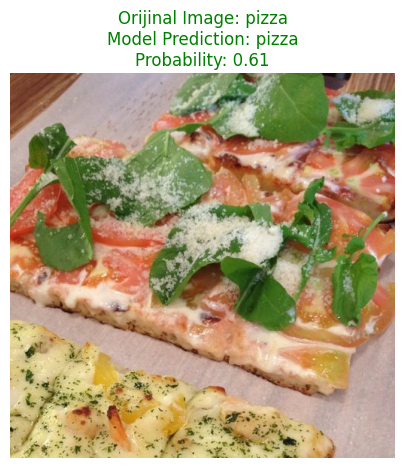

In [314]:
# Create five different random image and make predictions
for i in range(0, 6):
    pred_and_plot(create_random_image_and_path(), model_1)
    print('\n')